L'objectif de ce notebook est la création d'un dashboard décrivant les inégalités de temps de parole dans les médias entre les femmes et les hommes

# Imports

In [1]:
!pip install streamlit
!pip install gradio
!pip install squarify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.4/321.4 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [2]:

import matplotlib.pyplot as plt
import os
import pandas as pd
import gradio as gr
import io
import seaborn as sns
import squarify
import plotly.express as px
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import shutil
import os
import numpy as np
from sklearn.linear_model import LinearRegression


# Chargement des données

In [4]:
# Chemin des fichiers

chemin_donnees = os.path.join("..", "Data")

dossier_fichier_hoursatall= os.path.join(chemin_donnees, "Temps de parole des hommes et des femmes à la Tv et radio", "20190308-hourstatall.csv")

dossier_fichier_years=os.path.join(chemin_donnees, "Temps de parole des hommes et des femmes à la Tv et radio", "20190308-years.csv")

dossier_fichier_declarations = os.path.join(chemin_donnees, "Temps de parole des femmes et des hommes dans les programmes ayant fait l'objet d’une déclaration au CSA pour son rapport portant sur la représentation des femmes à la télévision et la radio", "ina-csa-parole-femmes-chaines.csv")

df_hours_at_all = pd.read_csv(dossier_fichier_hoursatall, encoding='utf-8',sep=',')
df_hours_at_all['is_public_channel'] = df_hours_at_all['is_public_channel'].replace({True: 'Publique', False: 'Privé'})

df_years=pd.read_csv(dossier_fichier_years,encoding='utf-8',sep=',')
df_years['is_public_channel'] = df_years['is_public_channel'].replace({True: 'Publique', False: 'Privé'})

df_declarations = pd.read_csv(dossier_fichier_declarations, encoding='utf-8',sep=',')


In [5]:
#On construit ici le dictionnaire qui associe pour chaque radio présente dans le csv df_declarations, la valeur "Publique" (média public) et "Privé" (média privé)
#On va l'utiliser dans la fonction assign_themes afin de constuire la colonne is_public_channel dans le csv df_declarations
is_public_channel = {
    "Europe 1": "Privé",
    "Fip": "Publique",
    "France Culture": "Publique",
    "France Info": "Publique",
    "France Inter": "Publique",
    "France Musique": "Publique",
    "FunRadio": "Privé",
    "Mouv": "Publique",
    "NOSTALGIE": "Privé",
    "NRJ": "Privé",
    "RFI": "Publique",
    "RMC": "Privé",
    "RTL": "Privé",
    "6TER": "Privé",
    "BFMTV": "Privé",
    "C8": "Privé",
    "CANAL PLUS": "Privé",
    "CNEWS": "Privé",
    "Chérie 25": "Privé",
    "FRANCE 2": "Publique",
    "FRANCE 3": "Publique",
    "FRANCE 4": "Publique",
    "FRANCE 5": "Publique",
    "France 24": "Publique",
    "L'Equipe": "Privé",
    "LCI": "Privé",
    "M6": "Privé",
    "NRJ 12": "Privé",
    "RMC Découverte": "Privé",
    "RMC Story": "Privé",
    "TF1": "Privé",
    "TFX": "Privé",
    "TMC": "Privé",
    "W9": "Privé",
    "franceinfo": "Publique",
    "Virgin Radio ": "Privé",
    "CSTAR": "Privé",
    "France ô": "Publique",
    "GULLI": "Privé",
    "Paris Première": "Privé"
}

In [6]:
# Dictionnaire des thèmes et des chaînes associées
themes = {
    'Sport': ['canal+ sport', 'eurosport france', "l'equipe 21", "l'equipe"],
    'Musique': ['chérie fm', 'france musique', 'fun radio', 'funradio', 'mouv', 'nrj', 'nostalgie', 'rfm',
                'rtl 2', 'radio classique', 'skyrock', 'virgin radio', 'virgin radio ', 'cstar'],
    'Information': ['europe 1', 'france info', 'franceinfo', 'rfi', 'rmc', 'sud radio', 'bfm tv', 'euronews', 'france 24',
                    'i-télé/cnews', 'cnews', 'lci', 'lcp/public sénat', 'la chaîne météo', 'bfmtv'],
    'Culture': ['france bleu', 'france culture', 'animaux', 'chasse et pêche', 'france 5', 'histoire',
                'planète+', 'tv5 monde', "toute l'histoire", 'voyage', 'france 4'],
    'Tout': ['france inter', 'rtl', 'arte', 'canal+', 'canal plus', 'd8/c8', 'c8', 'france 2', 'france 3', 'france o', 'm6', 'nrj 12', 'tf1', 'tv breizh', 'rmc story', 'tfx'],
    'Divertissement': ['rire et chansons', 'chérie 25', 'comédie+', 'paris première', 'téva', 'w9', 'fip', '6ter', 'rmc découverte', 'tmc', 'monte carlo tmc', 'gulli']
}

import unicodedata

# Fonction pour normaliser les chaînes (supprimer les accents et caractères spéciaux)
def normalize_string(s):
    if isinstance(s, str):
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
        ).lower()
    return s

# Fonction pour affecter les thèmes en utilisant le dictionnaire
def assign_themes(df, themes):
    # Trouver la colonne contenant les noms des chaînes
    column_name = None
    for possible_name in ['channel_name', 'Editeur']:
        if possible_name in df.columns:
            column_name = possible_name
            break

    if not column_name:
        raise ValueError("Aucune colonne pour les noms des chaînes n'a été trouvée dans le DataFrame.")

    # Normaliser la colonne contenant les noms des chaînes
    df['channel_name_normalized'] = df[column_name].apply(normalize_string)

    # Initialiser la colonne 'thème de la chaine' à None
    df['thème de la chaine'] = None

    # Normaliser les chaînes du dictionnaire et affecter les thèmes
    for theme, channels in themes.items():
        normalized_channels = [normalize_string(channel) for channel in channels]
        index_theme = df.index[df['channel_name_normalized'].isin(normalized_channels)].tolist()
        df.loc[index_theme, 'thème de la chaine'] = theme

    # Cas spécifique pour le csv du nombre de déclarations par chaine : la colonne is_public_channel n'est pas présente : on doit la reconstruire à partir du dictionnaire
    if column_name == "Editeur":
      df['is_public_channel'] = None
      # Utiliser le dictionnaire is_public_channel pour affecter les valeurs
      normalized_public_channel_dict = {normalize_string(k): v for k, v in is_public_channel.items()}
      df['is_public_channel'] = df['channel_name_normalized'].map(normalized_public_channel_dict)

    # Supprimer la colonne intermédiaire utilisée pour la correspondance
    df.drop(columns=['channel_name_normalized'], inplace=True)
    return df

# Appliquer la fonction aux DataFrames
df_years = assign_themes(df_years, themes)
df_hours_at_all = assign_themes(df_hours_at_all, themes)
df_declarations = assign_themes(df_declarations, themes)



In [7]:
#Ajout de la colonne représantant l'evolution ddu women speech rate dans le csv df_declarations
df_declarations["evolution_women_expression_rate_2019_2020"] = df_declarations['women_expression_rate_2020'] - df_declarations['women_expression_rate_2019']
df_declarations['nb_declarations_2019'] = df_declarations['nb_declarations_2019'].fillna(0)

# Définition des filtres

In [8]:
#Définition des filtres qui seront utilisés dans le dashboard
liste_themes=df_years["thème de la chaine"].unique().tolist()
liste_public_prive=df_years["is_public_channel"].unique().tolist()
liste_types_media=df_years["media_type"].unique().tolist()
liste_types_media.append("Cumulé")
liste_public_prive.append("Cumulé")
liste_themes.append("Cumulé")

# Définition des fonctions pour générer les graphiques du dashboard

## Graphique camembert du taux d'expression des femmes pour une année

In [9]:
# Fonction pour générer le camembert
def generer_women_rate_by_year(year_selection):
    if year_selection == "Moyenne":
        # Calculer la moyenne du taux pour toutes les années pour hommes et femmes
        women_mean = df_years["women_expression_rate"].mean()
        men_mean = 100-women_mean
        grouped = pd.DataFrame({
            "Category": ["Femmes", "Hommes"],
            "Rate": [women_mean, men_mean]
        })
    else:
        # Filtrer les données pour l'année sélectionnée
        df_filtered = df_years[df_years["year"] == int(year_selection)]
        if df_filtered.empty:
            return "Aucune donnée disponible"

        # Organiser les données pour le camembert
        women_rate = df_filtered["women_expression_rate"].mean()
        men_rate = 100 - women_rate
        grouped=pd.DataFrame({
            "Category": ["Femmes", "Hommes"],
            "Rate": [women_rate, men_rate]
        })

    # Création du diagramme camembert avec Plotly
    fig = px.pie(
        grouped,
        names="Category",
        values="Rate",
        title=f"Comparaison du taux d'expression dans les médias radio et tv des hommes et des femmes {'Moyenne' if year_selection == 'Moyenne' else f'en {year_selection}'}",
        #color_discrete_sequence=px.colors.qualitative.Pastel
        #color_discrete_sequence=["#0223df", "#f90123"]
        color_discrete_sequence=["#BC8CF9", "#44D6B3"]
    )
    fig.update_traces(textinfo="percent+label", hole=0.3)

    return fig


## Graphique du taux de parole des femmes en fonctions des années

In [10]:
def generer_women_rate_years(media_type_selection, public_prive_selection, themes_selection):
    # Vérifier que les sélections ne sont pas vides
    if not themes_selection or not public_prive_selection or not media_type_selection:
        return "Veuillez sélectionner au moins une valeur dans chaque filtre."

    # Cas où "Cumulé" est sélectionné dans tous les filtres
    if "Cumulé" in themes_selection and "Cumulé" in public_prive_selection and "Cumulé" in media_type_selection:
        grouped = df_years.groupby(['year'])[['women_expression_rate']].mean().reset_index()
        grouped['thème de la chaine'] = "Cumulé"
        grouped['is_public_channel'] = "Cumulé"
        grouped['media_type'] = "Cumulé"

    # Cas où "Cumulé" est sélectionné dans themes_selection et public_prive_selection
    elif "Cumulé" in themes_selection and "Cumulé" in public_prive_selection:
        grouped = df_years.groupby(['year', 'media_type'])[['women_expression_rate']].mean().reset_index()
        grouped = grouped[grouped['media_type'].isin(media_type_selection)]
        grouped['thème de la chaine'] = "Cumulé"
        grouped['is_public_channel'] = "Cumulé"

    # Cas où "Cumulé" est sélectionné dans themes_selection et media_type_selection
    elif "Cumulé" in themes_selection and "Cumulé" in media_type_selection:
        grouped = df_years.groupby(['year', 'is_public_channel'])[['women_expression_rate']].mean().reset_index()
        grouped = grouped[grouped['is_public_channel'].isin(public_prive_selection)]
        grouped['thème de la chaine'] = "Cumulé"
        grouped['media_type'] = "Cumulé"

    # Cas où "Cumulé" est sélectionné dans media_type_selection et public_prive_selection
    elif "Cumulé" in media_type_selection and "Cumulé" in public_prive_selection:
        grouped = df_years.groupby(['year', 'thème de la chaine'])[['women_expression_rate']].mean().reset_index()
        grouped = grouped[grouped['thème de la chaine'].isin(themes_selection)]
        grouped['is_public_channel'] = "Cumulé"
        grouped['media_type'] = "Cumulé"

    # Cas où "Cumulé" est sélectionné dans themes_selection uniquement
    elif "Cumulé" in themes_selection:
        grouped = df_years.groupby(['year', 'is_public_channel', 'media_type'])[['women_expression_rate']].mean().reset_index()
        grouped = grouped[
            grouped['is_public_channel'].isin(public_prive_selection) &
            grouped['media_type'].isin(media_type_selection)
        ]
        grouped['thème de la chaine'] = "Cumulé"

    # Cas où "Cumulé" est sélectionné dans public_prive_selection uniquement
    elif "Cumulé" in public_prive_selection:
        grouped = df_years.groupby(['year', 'thème de la chaine', 'media_type'])[['women_expression_rate']].mean().reset_index()
        grouped = grouped[
            grouped['thème de la chaine'].isin(themes_selection) &
            grouped['media_type'].isin(media_type_selection)
        ]
        grouped['is_public_channel'] = "Cumulé"

    # Cas où "Cumulé" est sélectionné dans media_type_selection uniquement
    elif "Cumulé" in media_type_selection:
        grouped = df_years.groupby(['year', 'thème de la chaine', 'is_public_channel'])[['women_expression_rate']].mean().reset_index()
        grouped = grouped[
            grouped['thème de la chaine'].isin(themes_selection) &
            grouped['is_public_channel'].isin(public_prive_selection)
        ]
        grouped['media_type'] = "Cumulé"

    # Cas général : aucun "Cumulé" sélectionné
    else:
        df_filtered = df_years[
            (df_years["thème de la chaine"].isin(themes_selection)) &
            (df_years["is_public_channel"].isin(public_prive_selection)) &
            (df_years["media_type"].isin(media_type_selection))
        ]
        if df_filtered.empty:
            return px.scatter(title="Aucune donnée disponible", x=[], y=[])
        grouped = df_filtered.groupby(['year', 'thème de la chaine', 'is_public_channel', 'media_type'])[['women_expression_rate']].mean().reset_index()

    if grouped.empty:
        return px.scatter(title="Aucune donnée disponible", x=[], y=[])

    # Création du graphique avec Plotly
    fig = px.line(
        grouped,
        x='year',
        y='women_expression_rate',
        color='thème de la chaine',          # Différencier par thème
        line_dash='is_public_channel',      # Différencier par catégorie
        symbol='media_type',                # Différencier par type
        markers=True,                       # Ajouter des marqueurs
        labels={
            "year": "Année",
            "women_expression_rate": "Taux d'expression des femmes (%)",
            "thème de la chaine": "Thème",
            "is_public_channel": "Catégorie",
            "media_type": "Type de média"
        },
        title="Taux d'expression des femmes en fonction des années"
    )

    # Personnalisation des axes
    fig.update_layout(
        xaxis=dict(tickmode='linear', tick0=grouped['year'].min(), dtick=1),
        legend_title="",
        title_x=0.5
    )

    return fig

## Graphique du taux de parole des femmes en fonction des tranches horaires

In [11]:
def generer_tranches_horaires(media_type_selection, public_prive_selection, themes_selection):

    if not themes_selection or not public_prive_selection or not media_type_selection:
        return "Veuillez sélectionner au moins une valeur dans chaque filtre."

    # Cas où "Cumulé" est sélectionné dans tous les filtres
    if "Cumulé" in themes_selection and "Cumulé" in public_prive_selection and "Cumulé" in media_type_selection:
        grouped = df_hours_at_all.groupby(['hour'])[['women_expression_rate']].mean().reset_index()
        grouped['thème de la chaine'] = "Cumulé"
        grouped['is_public_channel'] = "Cumulé"
        grouped['media_type'] = "Cumulé"

    # Cas où "Cumulé" est sélectionné dans themes_selection et public_prive_selection
    elif "Cumulé" in themes_selection and "Cumulé" in public_prive_selection:
        grouped = df_hours_at_all.groupby(['hour', 'media_type'])[['women_expression_rate']].mean().reset_index()
        grouped = grouped[grouped['media_type'].isin(media_type_selection)]
        grouped['thème de la chaine'] = "Cumulé"
        grouped['is_public_channel'] = "Cumulé"

    # Cas où "Cumulé" est sélectionné dans themes_selection et media_type_selection
    elif "Cumulé" in themes_selection and "Cumulé" in media_type_selection:
        grouped = df_hours_at_all.groupby(['hour', 'is_public_channel'])[['women_expression_rate']].mean().reset_index()
        grouped = grouped[grouped['is_public_channel'].isin(public_prive_selection)]
        grouped['thème de la chaine'] = "Cumulé"
        grouped['media_type'] = "Cumulé"

    # Cas où "Cumulé" est sélectionné dans media_type_selection et public_prive_selection
    elif "Cumulé" in media_type_selection and "Cumulé" in public_prive_selection:
        grouped = df_hours_at_all.groupby(['hour', 'thème de la chaine'])[['women_expression_rate']].mean().reset_index()
        grouped = grouped[grouped['thème de la chaine'].isin(themes_selection)]
        grouped['is_public_channel'] = "Cumulé"
        grouped['media_type'] = "Cumulé"

    # Cas où "Cumulé" est sélectionné dans themes_selection uniquement
    elif "Cumulé" in themes_selection:
        grouped = df_hours_at_all.groupby(['hour', 'is_public_channel', 'media_type'])[['women_expression_rate']].mean().reset_index()
        grouped = grouped[
            grouped['is_public_channel'].isin(public_prive_selection) &
            grouped['media_type'].isin(media_type_selection)
        ]
        grouped['thème de la chaine'] = "Cumulé"

    # Cas où "Cumulé" est sélectionné dans public_prive_selection uniquement
    elif "Cumulé" in public_prive_selection:
        grouped = df_hours_at_all.groupby(['hour', 'thème de la chaine', 'media_type'])[['women_expression_rate']].mean().reset_index()
        grouped = grouped[
            grouped['thème de la chaine'].isin(themes_selection) &
            grouped['media_type'].isin(media_type_selection)
        ]
        grouped['is_public_channel'] = "Cumulé"

    # Cas où "Cumulé" est sélectionné dans media_type_selection uniquement
    elif "Cumulé" in media_type_selection:
        grouped = df_hours_at_all.groupby(['hour', 'thème de la chaine', 'is_public_channel'])[['women_expression_rate']].mean().reset_index()
        grouped = grouped[
            grouped['thème de la chaine'].isin(themes_selection) &
            grouped['is_public_channel'].isin(public_prive_selection)
        ]
        grouped['media_type'] = "Cumulé"

    # Cas général : aucun "Cumulé" sélectionné
    else:
        df_filtered = df_hours_at_all[
            (df_hours_at_all["thème de la chaine"].isin(themes_selection)) &
            (df_hours_at_all["is_public_channel"].isin(public_prive_selection)) &
            (df_hours_at_all["media_type"].isin(media_type_selection))
        ]
        if df_filtered.empty:
            return px.scatter(title="Aucune donnée disponible", x=[], y=[])
        grouped = df_filtered.groupby(['hour', 'thème de la chaine', 'is_public_channel', 'media_type'])[['women_expression_rate']].mean().reset_index()

    if grouped.empty:
        return px.scatter(title="Aucune donnée disponible", x=[], y=[])

    # Création du graphique avec Plotly
    fig = px.line(
        grouped,
        x='hour',
        y='women_expression_rate',
        color='thème de la chaine',          # Différencier par thème
        line_dash='is_public_channel',      # Différencier par catégorie
        symbol='media_type',
        markers=True,                # Ajouter des marqueurs sur les lignes
        labels={
            "hour": "Tranche horaire",
            "women_expression_rate": "Taux d'expression des femmes (%)",
            "thème de la chaine" : "Thème",
            "media_type": "Type de média",  # Personnaliser le titre de la légende
            "is_public_channel": "Catégorie",  # Personnaliser le titre de la légende
        },
        title="Taux d'expression des femmes en fonction des tranches horaires"
    )

    # Personnalisation des axes
    fig.update_layout(
        xaxis=dict(tickmode='linear', tick0=grouped['hour'].min(), dtick=1),  # Ticks pour les heures
        legend_title="",
        title_x=0.5  # Centrer le titre
    )

    return fig

## Graphique du taux de parole des femmes en fonction du taux de parole global (100 - taux de musique)

In [12]:
def generer_graphe_women_rate_speech_rate(media_type_selection, themes_selection):
    # Filtrage pour exclure "Cumulé"
    if "Cumulé" in media_type_selection:
        media_type_selection = [item for item in media_type_selection if item != "Cumulé"]

    if "Cumulé" in themes_selection:
        themes_selection = [item for item in themes_selection if item != "Cumulé"]

    # Filtrage des données en fonction des sélections
    df_filtered = df_years[
        (df_years["media_type"].isin(media_type_selection)) &
        (df_years["thème de la chaine"].isin(themes_selection))
    ]

    if df_filtered.empty:
        return px.scatter(title="Aucune donnée disponible", x=[], y=[])

    # Regrouper les données par `channel_name` pour calculer les moyennes
    grouped = df_filtered.groupby(['channel_name', 'thème de la chaine', 'media_type']).agg({
        'women_expression_rate': 'mean',
        'speech_rate': 'mean',
        'nb_hours_analyzed': 'sum'  # Somme des heures analysées pour la taille des points
    }).reset_index()

    # Vérifier si `grouped` est vide après le regroupement
    if grouped.empty:
        return px.scatter(title="Aucune donnée disponible", x=[], y=[])

    # Création du graphique scatter avec Plotly Express
    fig = px.scatter(
        grouped,
        x="speech_rate",  # Axe des X : Moyenne du taux de parole (100 - musique)
        y="women_expression_rate",  # Axe des Y : Moyenne du taux de parole des femmes
        size="nb_hours_analyzed",  # Taille des points (basée sur le nombre total d'heures analysées)
        color="thème de la chaine",  # Couleur des points par type de média
        symbol="media_type",  # Forme des points par public/privé
        hover_name="channel_name",  # Nom de la chaîne au survol
        labels={
            "speech_rate": "Pourcentage de parole (100 - musique)",
            "women_expression_rate": "Pourcentage de parole des femmes",
            "thème de la chaine": "Thème",
            "media_type": "Type de média"
        },
        title="Taux de paroles des femmes en fonction du pourcentage <br> de parole global (100- pourcentage de musique)"
    )

    # Personnalisation du style des points
    fig.update_traces(marker=dict(line=dict(width=2)))  # Ajout d'un contour autour des points

    # Mise à jour des titres des axes et ajustement de l'apparence générale
    fig.update_layout(
        xaxis_title="Pourcentage de parole (100 - pourcentage de musique)",
        yaxis_title="Pourcentage de parole des femmes",
        legend_title="Légende",
        title_x=0.5  # Centrer le titre
    )

    # Retourner la figure
    return fig

## Graphique du taux de parole des femmes des chaînes ayant fait l'objet de déclarations au CSA

In [13]:
def generer_women_rate_nbr_decla(media_type_selection, public_prive_selection, themes_selection):

    if "Cumulé" in media_type_selection:
        media_type_selection = [item for item in media_type_selection if item != "Cumulé"]

    if "Cumulé" in public_prive_selection:
        public_prive_selection = [item for item in public_prive_selection if item != "Cumulé"]

    if "Cumulé" in themes_selection:
        themes_selection = [item for item in themes_selection if item != "Cumulé"]

    data_filtered = df_declarations[
        (df_declarations["media"].isin(media_type_selection))&
        (df_declarations["is_public_channel"].isin(public_prive_selection)) &
        (df_declarations["thème de la chaine"].isin(themes_selection))
    ]

    if data_filtered.empty:
       return px.scatter(title="Aucune donnée disponible", x=[], y=[])


    # Création du nuage de points
    fig = px.scatter(
    data_filtered,
    x="nb_declarations_2019",
    y="evolution_women_expression_rate_2019_2020",
    color="thème de la chaine",  # Différencie les éditeurs par couleur
    hover_data={
        "nb_declarations_2019": True,
        "evolution_women_expression_rate_2019_2020": True,
        "Editeur": True,
    },
    title="Évolution du temps de parole des femmes (2019-2020) <br> en fonction du nombre de déclarations en 2019",
    labels={
        "nb_declarations_2019": "Nombre de déclarations en 2019",
        "evolution_women_expression_rate_2019_2020": "Évolution du temps de parole en pourcentage",
        "Editeur": "Chaine",
        "thème de la chaine": "Thèmes"
        }
    )
    return fig

## Graphique du nombre de déclarations en 2019 en fonction du nombre de déclarations en 2020

In [14]:
def generer_nbr_decla_2019_nbr_decla_2020(themes_selection):

  if "Cumulé" in themes_selection:
      themes_selection = [item for item in themes_selection if item != "Cumulé"]

  data_filtered = df_declarations[(df_declarations["thème de la chaine"].isin(themes_selection))]

  if data_filtered.empty:
        return px.scatter(title="Aucune donnée disponible", x=[], y=[])

  fig = px.scatter(
    data_filtered,
    x="nb_declarations_2019",
    y="nb_declarations_2020",
    color="thème de la chaine",  # Différencie les éditeurs par couleur
    hover_data={
        "nb_declarations_2019": True,
        "nb_declarations_2020": True,
        "Editeur": True,
        "is_public_channel": True
    },
    title="Comparaison du nombre de déclarations entre 2019 et 2020",
    labels={
        "nb_declarations_2019": "Nombre de déclarations en 2019",
        "nb_declarations_2020": "Nombre de déclarations en 2020",
        "Editeur": "Chaine",
        "thème de la chaine": "Thèmes"
        }
    )

  return fig

# Graphique Prédiction de la Parité par chaine

In [15]:
# Filtrer les chaînes télé et radio
tv_channels = df_years[df_years["media_type"] == "tv"]["channel_name"].unique()
radio_channels = df_years[df_years["media_type"] == "radio"]["channel_name"].unique()

# Trier chaque groupe par ordre alphabétique
sorted_tv_channels = sorted(tv_channels)
sorted_radio_channels = sorted(radio_channels)

# Combiner les deux listes
liste_channel = sorted_tv_channels + sorted_radio_channels

In [16]:
def graphe_prediction_parite(channel_selection):
    # Filtrage des données
    df_filtered = df_years
    if channel_selection != "Moyenne":
        df_filtered = df_years[df_years["channel_name"] == channel_selection]

    # Gestion du cas vide
    if df_filtered.empty:
        fig = go.Figure()
        fig.update_layout(title="Aucune donnée disponible", xaxis_title="Année", yaxis_title="Taux d'expression")
        return fig

    # Vérification de la corrélation linéaire
    correlation = df_filtered['year'].corr(df_filtered['women_expression_rate'])
    print(correlation)
    if abs(correlation*correlation) < 0.5:
        return go.Figure().update_layout(title="Pas de relation linéaire détectée. Régression impossible.")

    # Régression linéaire
    X = df_filtered[['year']]
    y = df_filtered['women_expression_rate']

    model = LinearRegression()
    model.fit(X, y)

    # Calcul du coefficient R²
    r_squared = model.score(X, y)

    premiere_annee = sorted(X['year'].unique().tolist())[0]
    # Prédictions
    parite = (50 - model.intercept_) / model.coef_[0]
    zero = None
    if parite >= premiere_annee:
      x_min = df_filtered['year'].min()  # Début de la période d'étude
      x_max = int(parite) + 1 if parite >= x_min else df_filtered['year'].max()
      x = np.arange(int(x_min), x_max, 1)  # Prédictions limitées à cette période
    else:
      x_min = premiere_annee  # Début de la période d'étude
      zero = (0 - model.intercept_) / model.coef_[0]
      x_max = int(zero) + 1 if zero >= x_min else df_filtered['year'].max()
      x = np.arange(int(x_min), x_max, 1)  # Prédictions limitées à cette période
    y_pred = model.predict(x.reshape(-1, 1))

    # Création du graphique Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(
    x=x,
    y=y_pred,
    mode='lines',
    name='Prédiction',
    line=dict(color='#60dfa8')  # Définir la couleur de la ligne
))
    fig.add_trace(go.Scatter(
        x=df_filtered['year'],
        y=df_filtered['women_expression_rate'],
        mode='markers',
        name='Données réelles',
        marker=dict(color='#2d295a')
    ))

    # Ajout de la droite verticale à x = parité
    if x_min <= parite <= x_max:
        # Annotation sur l'axe des abscisses
        fig.add_annotation(
            x=int(parite),
            y=50,
            text=f"Parité ({int(parite)})",
            showarrow=True,
            arrowhead=2,
            ax=40,  # Ajustez la position du texte si nécessaire
            ay=-40,
            font=dict(
            family="Arial",  # Police de caractères (optionnelle)
            size=12,         # Taille de la police (optionnelle)
            color="red"      # Couleur du texte
        ),
        arrowcolor="red"  # Couleur de la flèche
        )
    if zero!= None:
        # Annotation sur l'axe des abscisses
        fig.add_annotation(
            x=int(zero),
            y=0,
            text=f"Zéro ({int(zero)})",
            showarrow=True,
            arrowhead=2,
            ax=40,  # Ajustez la position du texte si nécessaire
            ay=-40,
            font=dict(
            family="Arial",  # Police de caractères (optionnelle)
            size=12,         # Taille de la police (optionnelle)
            color="red"      # Couleur du texte
        ),
        arrowcolor="red"  # Couleur de la flèche
        )

    fig.add_annotation(
      x=df_filtered['year'].min(),  # Position en bas à gauche sur l'axe des x
      y=df_filtered['women_expression_rate'].min() if zero is not None else df_filtered['women_expression_rate'].max(),  # Bas si zero != None, haut sinon
      text=f"r = {correlation:.2f}<br>R² = {r_squared:.2f}",
      showarrow=False,
      font=dict(family="Arial", size=12, color="blue"),
      align="left",
      bordercolor="blue",
      borderwidth=1
    )
    fig.update_layout(
        title=f"Prédiction du taux de parole | {channel_selection}",
        xaxis_title="Année",
        yaxis_title="Taux d'expression (%)"
    )
    return fig

# Dashboard

In [23]:
# Interface utilisateur Gradio
with gr.Blocks() as demo:

    with gr.Row():
        with gr.Column():
            # Composant Dropdown pour sélectionner l'année ou "Moyenne"
          gr.Markdown("### Répartition du temps de parole Hommes/Femmes pour chaque Année")
          # Bouton pour générer le camembert
          btn1 = gr.Button("Générer le camembert")
          year_input = gr.Dropdown(
          label="Sélectionnez l'année :",
          choices=["Moyenne"] + sorted(df_years["year"].unique().astype(str).tolist()),
          value="Moyenne"  # Valeur par défaut
          )
          output_women_rate_by_year = gr.Plot()

    btn1.click(
        fn=generer_women_rate_by_year,
        inputs=[year_input],
        outputs=[output_women_rate_by_year]
    )

    media_input = gr.CheckboxGroup(
      label="Sélectionnez le type de média :",
      choices=liste_types_media,
      value=liste_types_media
    )

    is_publique_input = gr.CheckboxGroup(
      label="Sélectionnez la catégorie de média :",
      choices=liste_public_prive,  # Exemple : [True, False]
      value=liste_public_prive
    )

    themes_input = gr.CheckboxGroup(
        label="Sélectionnez le thème des chaînes:",
        choices=liste_themes,  # Exemple : [True, False]
        value=liste_themes
    )

    #Bouton pour générer les autres graphiques
    btn2 = gr.Button("Générer les graphiques")

    with gr.Row():
        with gr.Column():
            gr.Markdown("### Taux de parole des femmes au fil des années")
            output_women_rate_years = gr.Plot()

    with gr.Row():
        with gr.Column():
            gr.Markdown("### Taux de parole des femmes en fonction des tranches horaires")
            output_tranches_horaires = gr.Plot()
    with gr.Row():
        with gr.Column():
            gr.Markdown("### Taux de paroles des femmes en fonction du taux de parole (100 - taux de musique)")
            output_taux_parole = gr.Plot()
        with gr.Column():
            gr.Markdown("### Taux de parole des femmes concernant les chaines ayant fait l'objet de déclarations au CSA")
            output_csa = gr.Plot()
    with gr.Row():
        with gr.Column():
            gr.Markdown("### Comparaison du nombre de déclaration entre 2019 et 2020 pour chaque chaîne")
            output_decla = gr.Plot()

    channel_input = gr.Dropdown(
        label="Sélectionnez la chaîne :",
        choices=liste_channel,
        value="Moyenne"
    )

    with gr.Row():
       with gr.Column():
            gr.Markdown("### Prédiction de la parité par chaînes")
            btn3 = gr.Button("Générer la prédiction")
            output_parite = gr.Plot()


    # Définir les actions lors du clic sur le bouton
    def generer_tous_les_graphiques(media_type_selection, public_prive_selection, themes_selection):
      # Appeler les fonctions de génération des graphiques
      fig_tranches_horaires = generer_tranches_horaires(media_type_selection, public_prive_selection, themes_selection)
      fig_taux_parole = generer_graphe_women_rate_speech_rate(media_type_selection, themes_selection)
      fig_csa = generer_women_rate_nbr_decla(media_type_selection, public_prive_selection, themes_selection)
      fig_decla = generer_nbr_decla_2019_nbr_decla_2020(themes_selection)
      fig_women_rate_years = generer_women_rate_years(media_type_selection, public_prive_selection, themes_selection)

      # Retourner les figures
      return fig_tranches_horaires, fig_taux_parole, fig_csa, fig_decla, fig_women_rate_years


    btn2.click(
    fn = generer_tous_les_graphiques,
    inputs=[media_input, is_publique_input, themes_input],
    outputs=[output_tranches_horaires, output_taux_parole, output_csa, output_decla, output_women_rate_years]
    )

    btn3.click(
    fn = graphe_prediction_parite,
    inputs=channel_input,
    outputs= output_parite
    )

demo.launch()

/usr/local/lib/python3.11/dist-packages/gradio/components/dropdown.py:226: UserWarning: The value passed into gr.Dropdown() is not in the list of choices. Please update the list of choices to include: Moyenne or set allow_custom_value=True.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://41317df310467f389a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Graphique Evolution du taux d'expression des femmes des chaînes

In [18]:
first_last_years = df_years.loc[df_years.groupby('channel_name')['year'].idxmin().values]
first_last_years = first_last_years[['channel_name', 'women_expression_rate','media_type']]
first_last_years.columns = ['channel_name', 'first_year_women_rate','media_type']

first_last_years_max = df_years.loc[df_years.groupby('channel_name')['year'].idxmax().values]
first_last_years_max = first_last_years_max[['channel_name', 'women_expression_rate','media_type']]
first_last_years_max.columns = ['channel_name', 'last_year_women_rate','media_type']

first_last_years=pd.merge(first_last_years,first_last_years_max)
first_last_years["evolution"]=first_last_years["last_year_women_rate"]-first_last_years["first_year_women_rate"]

evolutiontv=first_last_years[first_last_years['media_type'] == 'tv']
evolutionradio=first_last_years[first_last_years['media_type'] == 'radio']

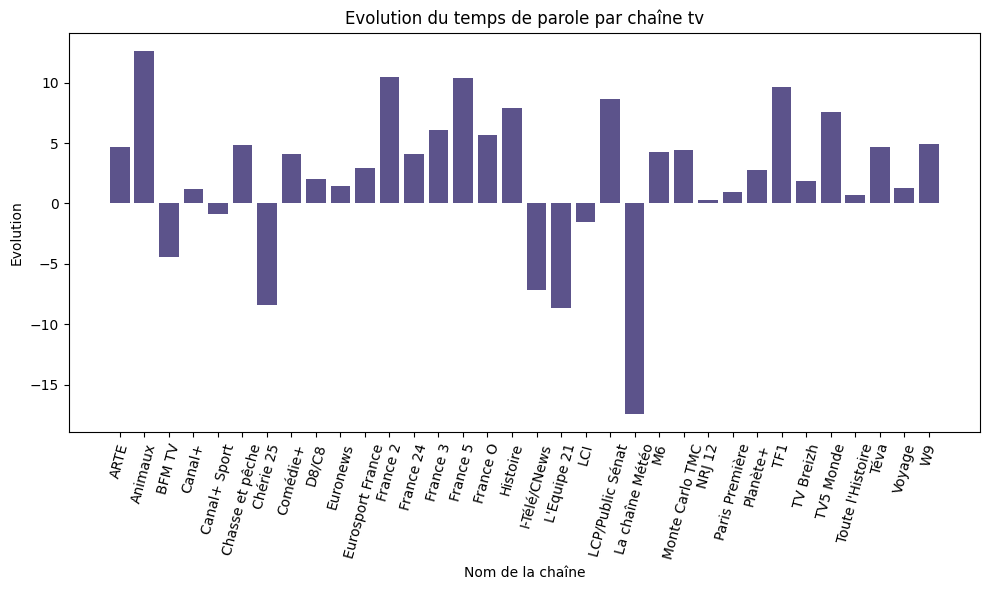

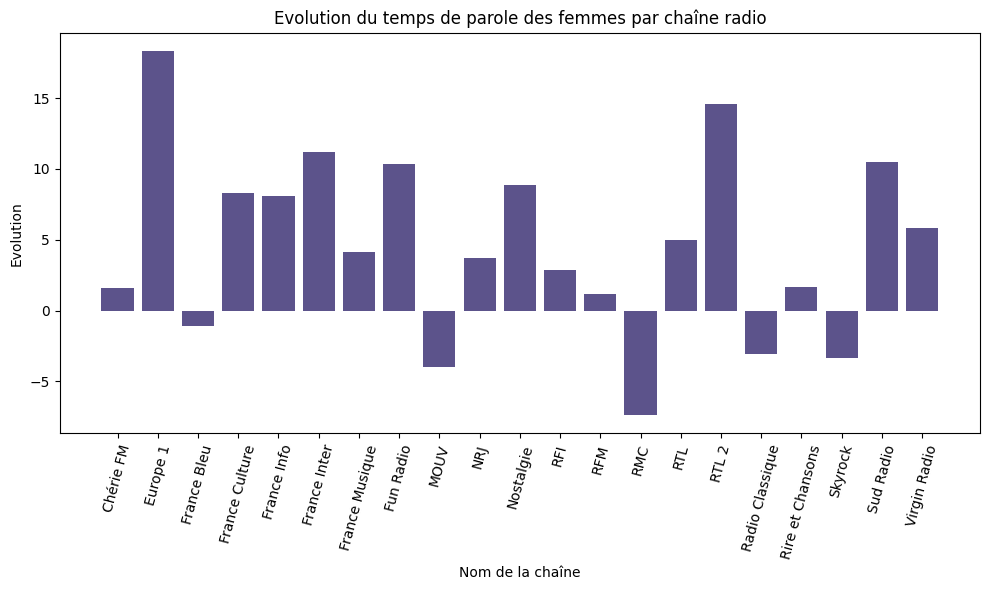

In [19]:
plt.figure(figsize=(10, 6))
plt.bar(evolutiontv['channel_name'], evolutiontv['evolution'],color='#5c538b' )
plt.xlabel("Nom de la chaîne")
plt.ylabel("Evolution")
plt.title("Evolution du temps de parole par chaîne tv")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))  # Ajuster la taille si nécessaire
plt.bar(evolutionradio['channel_name'], evolutionradio['evolution'],color="#5c538b")
plt.xlabel("Nom de la chaîne")
plt.ylabel("Evolution")
plt.title("Evolution du temps de parole des femmes par chaîne radio")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()